# Pneumonia Medical Imaging Analysis

In [1]:
# tensorflow packages 
import tensorflow as tf 

# general packages
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
import pathlib
from datetime import datetime


Tensorflow Version 

In [2]:
print("TensorFlow version: ", tf.__version__)
tf.get_logger().setLevel('ERROR')

TensorFlow version:  2.10.0


GPU Check 

In [3]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-04 13:44:04.531501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 13:44:04.531605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Seed

In [4]:
SEED = 0
np.random.seed(SEED)

## Image Preprocessing

Load Dataset

In [5]:
# Static variables
IMAGE_SIZE = 200
BATCH_SIZE = 32

# directory path 
data_file = './chest_xray'
data_dir = pathlib.Path(data_file)

# count number of images
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(f"Number of Images: {image_count}" )

Number of Images: 5856


Display a Sample Image

Image of a PNEUMONIA infected lung


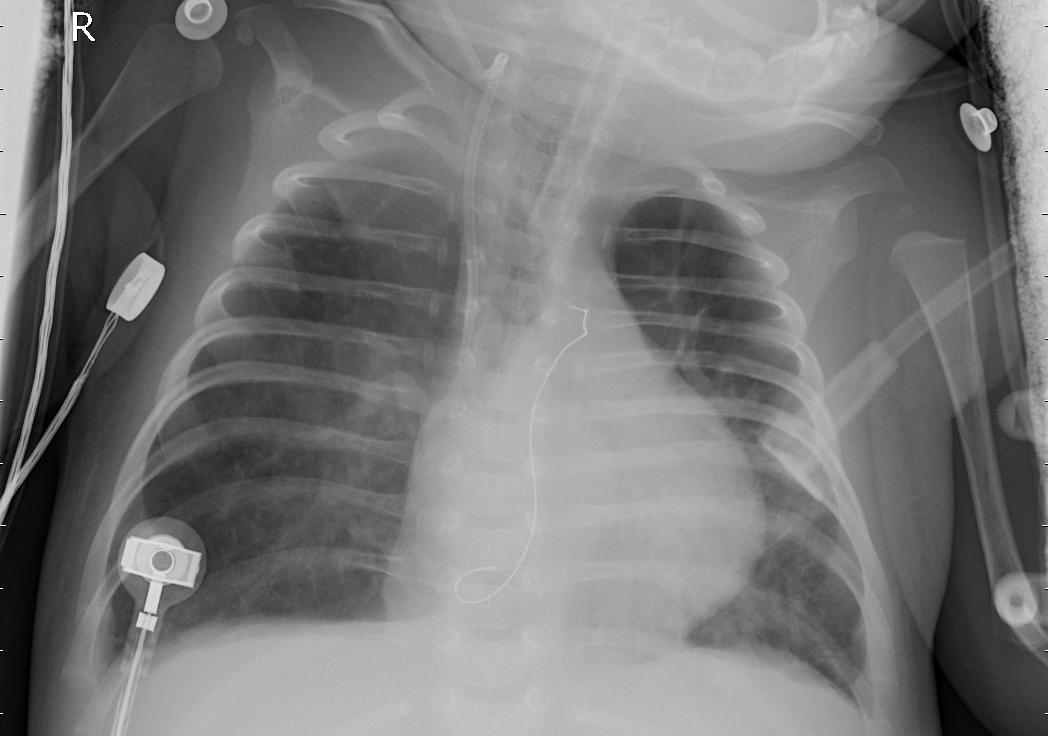

In [87]:
p = list(data_dir.glob('PNEUMONIA/*'))

print("Image of a PNEUMONIA infected lung")
PIL.Image.open(str(p[0]))

Establish Training and Validation Data Split 

In [47]:
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= 'inferred',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= 'inferred',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

labels = train.class_names

Found 5856 files belonging to 2 classes.
Using 4685 files for training.
Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


Dataset Tensorflow Optimization 

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

### Create and Fit Model   

Preprocessing Layer

In [9]:
preprocessing_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # resize 
    tf.keras.layers.Rescaling(1./255), # rescale
    tf.keras.layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)), # flip
    tf.keras.layers.RandomRotation(0.3), # rotate
    tf.keras.layers.RandomZoom(0.2), # zoom
])

Model 

In [10]:
num_classes = 2

model = tf.keras.Sequential([
  preprocessing_layer,
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Compile Model 

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Fit the Model onto the Dataset

In [12]:
# number of epochs 
epochs = 20

# Early Stopping callback to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '500,520')

# fit model
history = model.fit(
  train,
  validation_data= val,
  epochs=epochs,
  callbacks= [es, tboard],
)

Epoch 1/20


2022-12-04 13:44:05.451518: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-12-04 13:44:05.451525: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-12-04 13:44:05.451988: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-12-04 13:44:06.977114: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 13:44:06.979598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7270

2022-12-04 13:45:09.259918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - 66s 432ms/step - loss: 0.5978 - accuracy: 0.7270 - val_loss: 0.5738 - val_accuracy: 0.7404
Epoch 2/20
147/147 [==============================] - 58s 398ms/step - loss: 0.5922 - accuracy: 0.7270 - val_loss: 0.5742 - val_accuracy: 0.7404
Epoch 3/20
147/147 [==============================] - 58s 397ms/step - loss: 0.5870 - accuracy: 0.7270 - val_loss: 0.5727 - val_accuracy: 0.7404
Epoch 4/20
 58/147 [==========>...................] - ETA: 34s - loss: 0.5722 - accuracy: 0.7322

2022-12-04 13:47:30.893969: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-12-04 13:47:30.893982: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 78/147 [==============>...............] - ETA: 26s - loss: 0.5720 - accuracy: 0.7288

2022-12-04 13:47:39.062895: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-12-04 13:47:39.447734: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-12-04 13:47:39.661913: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20221204-134405/plugins/profile/2022_12_04_13_47_39

2022-12-04 13:47:39.953461: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20221204-134405/plugins/profile/2022_12_04_13_47_39/Hammers-Air.attlocal.net.trace.json.gz
2022-12-04 13:47:40.102925: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20221204-134405/plugins/profile/2022_12_04_13_47_39

2022-12-04 13:47:40.107474: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/20221204-134405/plugins/profile/2022_12_04_13_47_39/Hammers-Air.a

147/147 [==============================] - 60s 406ms/step - loss: 0.5669 - accuracy: 0.7208 - val_loss: 0.5125 - val_accuracy: 0.7404
Epoch 5/20
147/147 [==============================] - 58s 397ms/step - loss: 0.5195 - accuracy: 0.7407 - val_loss: 0.4767 - val_accuracy: 0.7746
Epoch 6/20
147/147 [==============================] - 59s 398ms/step - loss: 0.4954 - accuracy: 0.7535 - val_loss: 0.4425 - val_accuracy: 0.8104
Epoch 7/20
147/147 [==============================] - 59s 401ms/step - loss: 0.4770 - accuracy: 0.7708 - val_loss: 0.5369 - val_accuracy: 0.7515
Epoch 8/20
147/147 [==============================] - 59s 402ms/step - loss: 0.3861 - accuracy: 0.8305 - val_loss: 0.3232 - val_accuracy: 0.8599
Epoch 9/20
147/147 [==============================] - 59s 402ms/step - loss: 0.2988 - accuracy: 0.8677 - val_loss: 0.3241 - val_accuracy: 0.8582
Epoch 10/20
147/147 [==============================] - 61s 417ms/step - loss: 0.2960 - accuracy: 0.8717 - val_loss: 0.2926 - val_accuracy: 0.

Evaluate Model

In [19]:
%load_ext tensorboard
%tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17271), started 0:04:07 ago. (Use '!kill 17271' to kill it.)

Predictions

In [69]:
def predict(image_path):
    image = tf.keras.utils.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

    image_array = tf.keras.utils.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    return "{} with a {:.2f}% confidence ".format(labels[np.argmax(score)], 100 * np.max(score))

Predict a Normal Image

1/1 [==============================] - 0s 21ms/step
NORMAL with a 95.04% confidence 


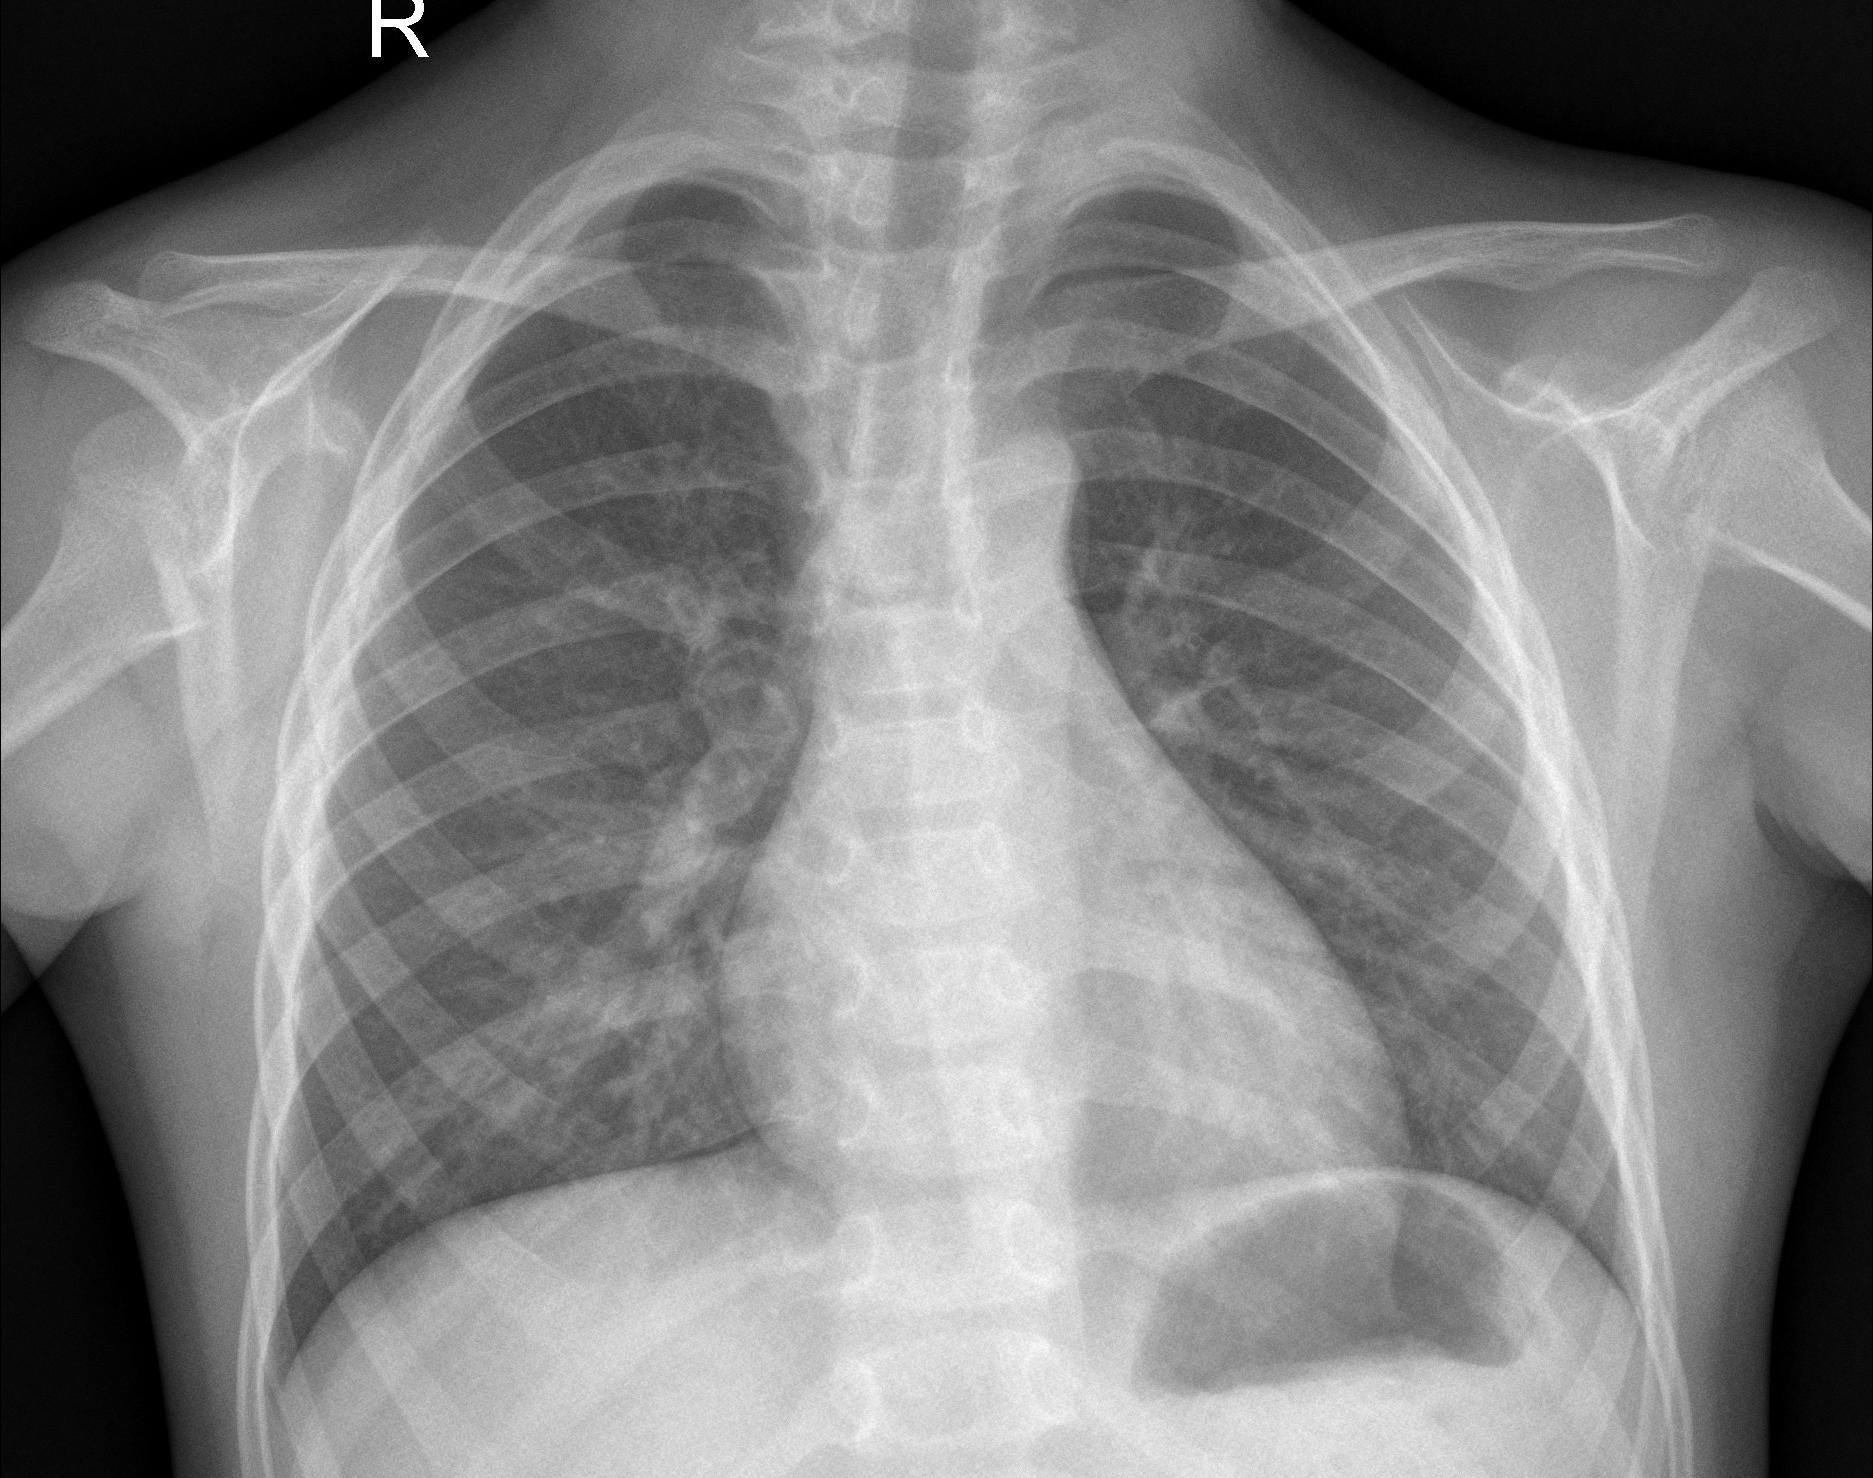

In [83]:
image_path = str(list(data_dir.glob('NORMAL/*'))[np.random.randint(0,len(list(data_dir.glob('NORMAL/*'))))])
print(predict(image_path))
PIL.Image.open(image_path)

Predict a Pneumonia Image

1/1 [==============================] - 0s 17ms/step
PNEUMONIA with a 99.41% confidence 


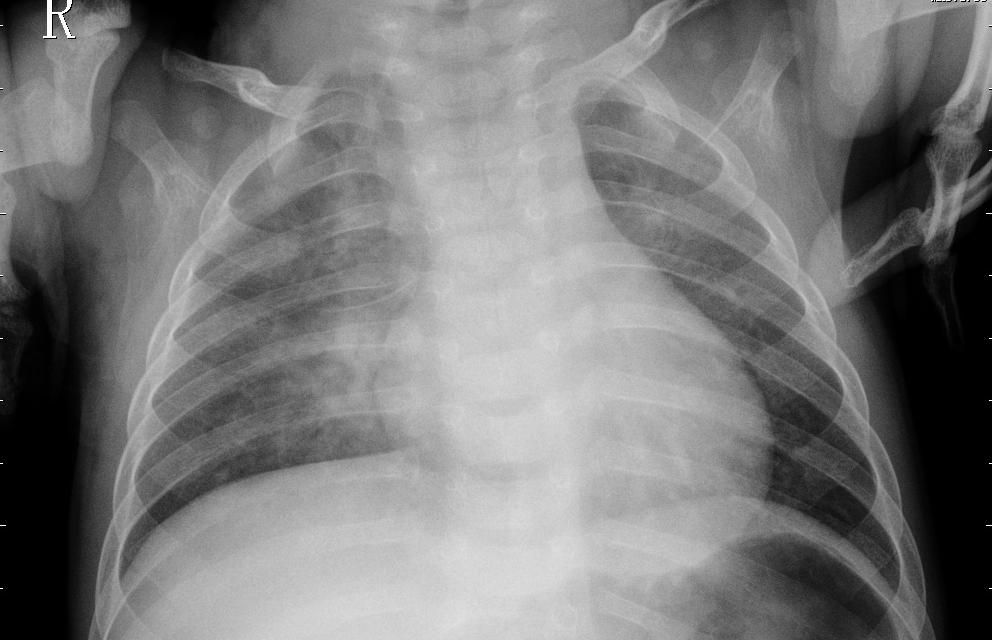

In [85]:
image_path = str(list(data_dir.glob('PNEUMONIA/*'))[np.random.randint(0,len(list(data_dir.glob('PNEUMONIA/*'))))])
print(predict(image_path))
PIL.Image.open(image_path)